In [1]:
!pip install osmnx

In [5]:
from typing import Union

from networkx import MultiDiGraph
from networkx import DiGraph

from matplotlib import pyplot

import networkx
import warnings
import osmnx
import json
import time
import ast
import os

warnings.filterwarnings('ignore')

## 1. Downloading and saving networks with OSMNX

In [6]:
#
# Networks (generated by this code)
# https://mega.nz/file/4gBT3BLA#EYhBJmAyZFAFHsunvo_4pSFgBIuq5dGlwvQknzbYy1s
#

def generate_osm (output_folder : str, country : str) -> Union[MultiDiGraph, DiGraph] :
    if not os.path.exists(output_folder) :
        os.makedirs(output_folder)

    file_basic = os.path.join(output_folder, f'{country.lower()}-basic.json')
    file_exten = os.path.join(output_folder, f'{country.lower()}-extended.json')
    file_image = os.path.join(output_folder, f'{country.lower()}.png')
    file_graph = os.path.join(output_folder, f'{country.lower()}.osm')

    timer = time.perf_counter()

    MAJOR_ROAD_FILTER = (
        f'["highway"]["area"!~"yes"]'
        f'["highway"!~"residential|escape|secondary_link|tertiary_link|living_street|crossing|speed_camera|traffic_signals|trailhead|stop|bus_stop|busway|toll_gantry|abandoned|traffic_mirror|bridleway|street_lamp|bus_guideway|construction|corridor|cycleway|elevator|escalator|footway|milestone|path|pedestrian|planned|platform|proposed|raceway|service|steps|track|emergency_bay|give_way"]'
        f'["service"!~"alley|driveway|emergency_access|parking|parking_aisle|private"]'
    )

    g = osmnx.graph_from_place(country, custom_filter = MAJOR_ROAD_FILTER)

    osmnx.plot_graph(g, filepath = file_image, show = False, save = True, dpi = 300)

    g = osmnx.distance.add_edge_lengths(g)
    g = osmnx.add_edge_speeds(g)
    g = osmnx.add_edge_travel_times(g)

    with open(file_basic, 'w') as file :
        json.dump(osmnx.basic_stats(g), file, indent = 4)

    with open(file_exten, 'w') as file :
        json.dump(osmnx.extended_stats(g), file, indent = 4)

    osmnx.save_graphml(g, file_graph)

    print(country)
    print(f'Nodes : {len(list(g.nodes))}')
    print(f'Edges : {len(list(g.edges))}')
    print(f'Timer : {(time.perf_counter() - timer):.2f} seconds')
    print()

    return g

Luxembourg
Nodes : 6040
Edges : 13165
Timer : 58.02 seconds

Montenegro
Nodes : 4030
Edges : 9288
Timer : 342.32 seconds

Slovenia
Nodes : 58102
Edges : 129037
Timer : 1150.02 seconds

Belgium
Nodes : 121760
Edges : 269478
Timer : 1578.37 seconds

Netherlands
Nodes : 252752
Edges : 566593
Timer : 18331.15 seconds



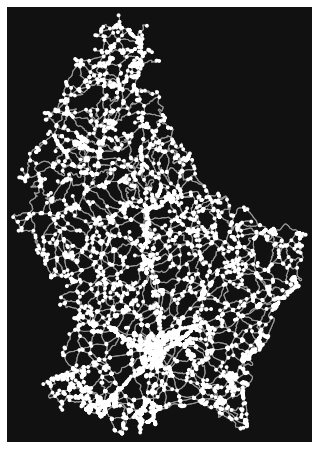

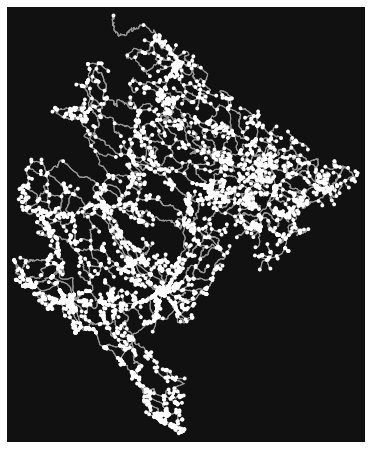

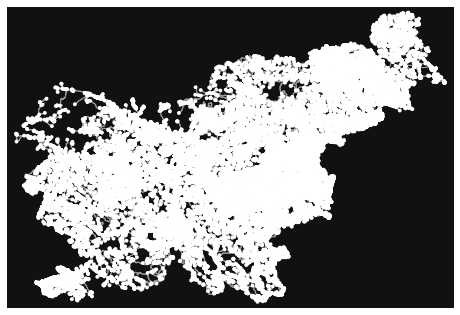

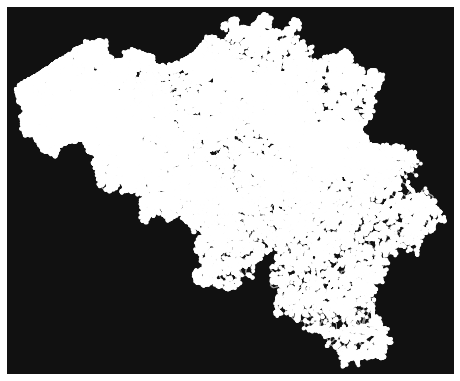

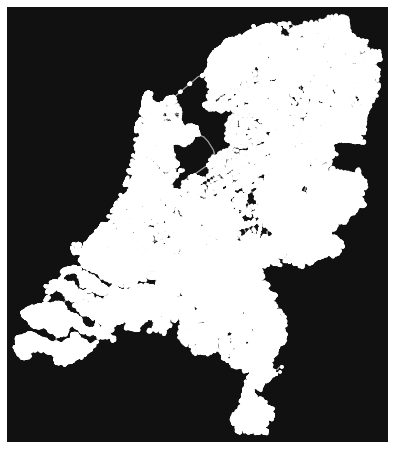

In [7]:
osmnx.config(use_cache = True, log_console = True)

ROOT_FOLDER = os.getcwd()
OUTPUT_FOLDER = os.path.join(ROOT_FOLDER, 'osm-network')

graphs = {}

for country in ['Luxembourg', 'Montenegro', 'Slovenia', 'Belgium', 'Netherlands'] :
    graphs[country] = generate_osm(output_folder = OUTPUT_FOLDER, country = country)

In [8]:
!zip -q -r osm-network.zip osm-network/

## 2. Reading the network with networkx and converting it into DiGraph

In [9]:
def load_networkx (filepath : str) -> DiGraph :
    g = networkx.read_graphml(filepath)

    dtypes = {
        "bearing": float,
        "grade": float,
        "grade_abs": float,
        "length": float,
        "osmid": int,
        "speed_kph": float,
        "travel_time": float,
    }

    for _, _, data in g.edges(data = True):
        data.pop("id", None)

        for attr, value in data.items():
            if value.startswith("[") and value.endswith("]"):
                try:
                    data[attr] = ast.literal_eval(value)
                except (SyntaxError, ValueError):
                    pass

        for attr in data.keys() & dtypes.keys():
            if isinstance(data[attr], list):
                data[attr] = [dtypes[attr](item) for item in data[attr]]
            else:
                data[attr] = dtypes[attr](data[attr])

    return DiGraph(g)

In [10]:
g = load_networkx(os.path.join(OUTPUT_FOLDER, 'luxembourg.osm'))

print(g)

for _, _, data in g.edges.data() :
    print(json.dumps(data, indent = 4))
    break

DiGraph with 6040 nodes and 13026 edges
{
    "osmid": [
        676494528,
        669225292,
        27911159,
        622769271,
        24477182,
        676491615
    ],
    "oneway": "True",
    "lanes": [
        "2",
        "3"
    ],
    "ref": "A 6",
    "name": "Autoroute d'Arlon",
    "highway": "motorway",
    "maxspeed": "130",
    "length": 3709.267,
    "bridge": "yes",
    "geometry": "LINESTRING (6.0136282 49.6387254, 6.0142127 49.6386874, 6.0151568 49.6386092, 6.0156678 49.6385571, 6.0165757 49.638452, 6.0175922 49.6383087, 6.0182708 49.638201, 6.0192825 49.6380163, 6.0203908 49.6377916, 6.0210527 49.6376396, 6.0217988 49.6374563, 6.0228882 49.6371573, 6.0240449 49.6368097, 6.0251503 49.6364362, 6.0267634 49.6358385, 6.0280162 49.6353654, 6.0306868 49.6343012, 6.0318534 49.6338548, 6.0326716 49.6335612, 6.0335048 49.6332732, 6.0345366 49.6329497, 6.0355873 49.63263, 6.0370415 49.632231, 6.0380332 49.6319834, 6.0392106 49.6317112, 6.0405706 49.6314348, 6.0414453 49.6